# 3 Hierarchical Classification SwDA

In [26]:
import time
import os
import pyhocon
import torch
import argparse
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.nn.functional import one_hot
import numpy as np
import glob
import os, re, json
import matplotlib.pyplot as plt
import jsonlines
import random
import torch.nn.functional as F
import math
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cophenet
from tqdm import tqdm

In [27]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')

## データ前処理

In [28]:
EOS_token = '<EOS>'
BOS_token = '<BOS>'
file_pattern = re.compile(r'^sw\_([a-z]+?)\_([0-9]+?)\.jsonlines$')

swda_tagu = {
    '<Uninterpretable>': ['abandoned_or_turn-exit/uninterpretable', 'non-verbal'],
    '<Statement>': ['statement-non-opinion', 'statement-opinion', 'other_answers', '3rd-party-talk', 'self-talk', 'offers,_options_commits', 'collaborative_completion'],
    '<Question>': ['q', 'yes-no-question', 'wh-question', 'declarative_yes-no-question', 'backchannel_in_question_form', 'open-question', 'rhetorical-questions', 'signal-non-understanding', 'or-clause', 'tag-question', 'declarative_wh-question'],
    '<Directive>': ['action-directive'],
    '<Greeting>': ['conventional-opening', 'conventional-closing'],
    '<Apology>': ['apology', 'no_answers', 'reject', 'negative_non-no_answers', 'dispreferred_answers', 'dispreferred_answers'],
    '<Agreement>': ['agree/accept', 'maybe/accept-part', 'thanking'],
    '<Understanding>': ['acknowledge_(backchannel)', 'summarize/reformulate', 'appreciation', 'response_acknowledgement', 'affirmative_non-yes_answers', 'yes_answers'],
    '<Other>': ['other', 'hedge', 'quotation', 'repeat-phrase', 'hold_before_answer/agreement', 'downplayer']
}

## 対話行為IDtoTAGU

In [29]:
tagu_to_ids = {
    'None': -1,
    '<Statement>': 0,
    'Other1': 1,
    '<Understanding>': 0, 
    'Other2': 1,
    '<Uninterpretable>': 0, 
    '<Agreement>': 1, 
    '<Question>': 2, 
    '<Other>': 3, 
    '<Apology>': 4, 
    '<Greeting>': 5, 
    '<Directive>': 6
}

In [30]:
class DA_to_ID_normal:
    
    def __init__(self, config, X_DA, Y_DA, name):
        self.word2id = None
        self.id2word = None
        self.config = config
        self.X_DA = X_DA
        self.Y_DA = Y_DA
        self.name = name
        self.construct()
        
    def construct(self):
#        vocab = {'<PAD>': 0}
        vocab = {}
        vocab_count = {}
        
        for x,y in zip(self.X_DA, self.Y_DA):
            for token in x:
                if token in vocab_count:
                    vocab_count[token] += 1
                else:
                    vocab_count[token] = 1
                    
            for token in y:
                if token in vocab_count:
                    vocab_count[token] += 1
                else:
                    vocab_count[token] = 1
                    
        for k, _ in sorted(vocab_count.items(), key=lambda x: -x[1]):
            vocab[k] = len(vocab)
            if len(vocab) >= self.config[self.name]['MAX_VOCAB']: break
        self.word2id = vocab
        self.id2word = {v : k for k, v in vocab.items()}
        return vocab
        
    def tokenize(self, X_tensor, Y_tensor):
        X_Tensor = [[self.word2id[token] for token in sentence] for sentence in X_tensor]
        Y_Tensor = [[self.word2id[token] for token in sentence] for sentence in Y_tensor]
        return X_Tensor, Y_Tensor

In [31]:
class DA_to_ID:
    
    def __init__(self, config, X_DA, Y_DA, name):
        self.word2id = None
        self.id2word = None
        self.config = config
        self.X_DA = X_DA
        self.Y_DA = Y_DA
        self.name = name
        self.construct()
        
    def construct(self):

        vocab = {}
        vocab_count = {}
        
        for x,y in zip(self.X_DA, self.Y_DA):
            for token in x:
                vocab[token] = tagu_to_ids[token]
            for token in y:
                vocab[token] = tagu_to_ids[token]
                    
        self.word2id = vocab
        self.id2word = {v : k for k, v in vocab.items()}
        return vocab
        
    def tokenize(self, X_tensor, Y_tensor):
        X_Tensor = [[self.word2id[token] for token in sentence] for sentence in X_tensor]
        Y_Tensor = [[self.word2id[token] for token in sentence] for sentence in Y_tensor]
        return X_Tensor, Y_Tensor

## Utterance IDtoWORD

In [7]:
class UTT_to_ID:
    
    def __init__(self, config, X_UTT, Y_UTT, name):
        self.word2id = None
        self.id2word = None
        self.config = config
        self.X_UTT = X_UTT
        self.Y_UTT = Y_UTT
        self.name = name
        self.construct()
        
    def construct(self):
        
        vocab = {'<UNK>': 0, '<EOS>': 1, '<BOS>': 2, '<UttPAD>': 3, '<ConvPAD>': 4}
        vocab_count = {}
        
        for x,y in zip(self.X_UTT, self.Y_UTT):
            for seq in x:
                for word in seq:
                    if word in vocab_count:
                        vocab_count[word] += 1
                    else:
                        vocab_count[word] = 1
            for seq in y:
                for word in seq:
                    if word in vocab_count:
                        vocab_count[word] += 1
                    else:
                        vocab_count[word] = 1
                        
        for k, _ in sorted(vocab_count.items(), key=lambda x: -x[1]):
            vocab[k] = len(vocab)
            if len(vocab) >= self.config[self.name]['UTT_MAX_VOCAB']: break
        self.word2id = vocab
        self.id2word = {v : k for k, v in vocab.items()}

        return vocab
        
    def tokenize(self, X_tensor, Y_tensor):
        
        X_Tensor = [[[self.word2id[token] if token in self.word2id else self.word2id['<UNK>'] for token in seq] for seq in dialogue] for dialogue in X_tensor]
        Y_Tensor = [[[self.word2id[token] if token in self.word2id else self.word2id['<UNK>'] for token in seq] for seq in dialogue] for dialogue in Y_tensor]
        return X_Tensor, Y_Tensor

## トレーニングデータ作成

In [8]:
def create_traindata(config, name):
    files = [f for f in os.listdir(config[name]['train_path']) if file_pattern.match(f)]
    # print("files:" , files)
    da_x, da_y, utt_x, utt_y, turn = [], [], [], [], []
    da_x1, da_x2, da_x3 = [], [], []
    da_y1, da_y2, da_y3 = [], [], []
    # 1file 1conversation
    for filename in files:
        # print(os.path.join(config['train_path'], filename))
        with open(os.path.join(config[name]['train_path'], filename), 'r') as f:
            data = f.read().split('\n')
            data.remove('')
            da_seq, utt_seq, turn_seq = [], [], []
            da1_seq, da2_seq, da3_seq = [], [], []
            # 1line 1turn
            for idx, line in enumerate(data, 1):
                jsondata = json.loads(line)
                # single-turn multi dialogue case
                for da, utt in zip(jsondata['DA'], jsondata['sentence']):
                    da_seq.append(da)
                    utt_seq.append(utt.split(' '))
                    turn_seq.append(0)
                for da1, da2, da3 in zip(jsondata['DA1'], jsondata['DA2'], jsondata['DA3']):
                    da1_seq.append(da1)
                    da2_seq.append(da2)
                    da3_seq.append(da3)
                        
                turn_seq[-1] = 1
            da_seq = [easy_damsl(da) for da in da_seq]
            
        if config[name]['state']:
            for i in range(max(1, len(da_seq) - 1 - config[name]['window_size'])):
                if len(da_seq)>=config[name]['window_size']:
                    ## 発話の対話行為
                    da_x.append(da_seq[i:min(len(da_seq)-1, i + config[name]['window_size'])])
                    da_x1.append(da1_seq[i:min(len(da1_seq)-1, i + config[name]['window_size'])])
                    da_x2.append(da2_seq[i:min(len(da2_seq)-1, i + config[name]['window_size'])])
                    da_x3.append(da3_seq[i:min(len(da3_seq)-1, i + config[name]['window_size'])])

                    ## 応答の対話行為
                    da_y.append(da_seq[1 + i:min(len(da_seq), 1 + i + config[name]['window_size'])])
                    da_y1.append(da1_seq[1 + i:min(len(da1_seq), 1 + i + config[name]['window_size'])])
                    da_y2.append(da2_seq[1 + i:min(len(da2_seq), 1 + i + config[name]['window_size'])])
                    da_y3.append(da3_seq[1 + i:min(len(da3_seq), 1 + i + config[name]['window_size'])])

                    ## 対話文
                    utt_x.append(utt_seq[i:min(len(da_seq)-1, i + config[name]['window_size'])])
                    utt_y.append(utt_seq[1 + i:min(len(da_seq), 1 + i + config[name]['window_size'])])

                    ## ターン制
                    turn.append(turn_seq[i:min(len(da_seq), i + config[name]['window_size'])])
    
    return da_x, da_x1, da_x2, da_x3, da_y, da_y1, da_y2, da_y3, utt_x, utt_y, turn

In [9]:
def easy_damsl(tag):
    easy_tag = [k for k, v in swda_tagu.items() if tag in v]
    return easy_tag[0] if not len(easy_tag) < 1 else tag

def separate_data(x, y, turn):
    split_size = round(len(x) / 10)
    if split_size == 0: split_size = 1
    X_train, Y_train, Tturn = x[split_size * 2:], y[split_size * 2:], turn[split_size * 2:]
    X_valid, Y_valid, Vturn = x[split_size: split_size * 2], y[split_size: split_size * 2], turn[split_size: split_size * 2]
    X_test, Y_test, Testturn = x[:split_size], y[:split_size], turn[:split_size]
    assert len(X_train) == len(Y_train), 'Unexpect to separate train data'
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, Tturn, Vturn, Testturn


def separate_data_da(x, y):
    split_size = round(len(x) / 10)
    if split_size == 0: split_size = 1
    X_train, Y_train = x[split_size * 2:], y[split_size * 2:]
    X_valid, Y_valid = x[split_size: split_size * 2], y[split_size: split_size * 2]
    X_test, Y_test = x[:split_size], y[:split_size]
    assert len(X_train) == len(Y_train), 'Unexpect to separate train data'
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

In [10]:
def initialize_env(name):
    config = pyhocon.ConfigFactory.parse_file('./dialogue.conf')
    config['log_dirs'] = os.path.join(config[name]['log_dir'])
    if not os.path.exists(config['log_dirs']):
        os.mkdir(config['log_dirs'])
     
    return config

def create_DAdata(config, name):
    da_x, da_x1, da_x2, da_x3, da_y, da_y1, da_y2, da_y3, _, _, _ = create_traindata(config, name)
    return da_x, da_x1, da_x2, da_x3, da_y, da_y1, da_y2, da_y3, _, _, _

def create_Uttdata(config, name):
    _, _, _, _, _, _, _, _, posts, cmnts, turn = create_traindata(config, name)
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test, Tturn, Vturn, Testturn = separate_data(posts, cmnts, turn)
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, Tturn, Vturn, Testturn


## データ分割

In [11]:
model_name="CmbAttention"
loss_name="Hire3"

In [12]:
write = SummaryWriter("./logs")
config = initialize_env(model_name+loss_name)

In [13]:
da_x, da_x1, da_x2, da_x3, da_y, da_y1, da_y2, da_y3, _, _, _ = create_DAdata(config, model_name+loss_name)
XDA_train,  YDA_train,  XDA_valid,  YDA_valid, _, _     = separate_data_da(da_x, da_y)
XDA1_train, YDA1_train, XDA1_valid, YDA1_valid, _, _ = separate_data_da(da_x1, da_y1)
XDA2_train, YDA2_train, XDA2_valid, YDA2_valid, _, _ = separate_data_da(da_x2, da_y2)
XDA3_train, YDA3_train, XDA3_valid, YDA3_valid, _, _ = separate_data_da(da_x3, da_y3)

In [14]:
DA_vocab  = DA_to_ID_normal(config, XDA_train+XDA_valid,   YDA_train+YDA_valid,   model_name+loss_name)
DA1_vocab = DA_to_ID(config, XDA1_train+XDA1_valid, YDA1_train+YDA1_valid, model_name+loss_name)
DA2_vocab = DA_to_ID(config, XDA2_train+XDA2_valid, YDA2_train+YDA2_valid, model_name+loss_name)
DA3_vocab = DA_to_ID(config, XDA3_train+XDA3_valid, YDA3_train+YDA3_valid, model_name+loss_name)

In [15]:
XUtt_train, YUtt_train, XUtt_valid, YUtt_valid, _, _, Tturn, Vturn, _ = create_Uttdata(config, model_name+loss_name)
Utt_vocab = UTT_to_ID(config, XUtt_train+XUtt_valid, YUtt_train+YUtt_valid, model_name+loss_name)

In [16]:
## 対話行為
XDA_train,  YDA_train  = DA_vocab.tokenize(XDA_train, YDA_train)
XDA1_train, YDA1_train = DA1_vocab.tokenize(XDA1_train, YDA1_train)
XDA2_train, YDA2_train = DA2_vocab.tokenize(XDA2_train, YDA2_train)
XDA3_train, YDA3_train = DA3_vocab.tokenize(XDA3_train, YDA3_train)

XDA_valid,  YDA_valid  = DA_vocab.tokenize(XDA_valid, YDA_valid)
XDA1_valid, YDA1_valid = DA1_vocab.tokenize(XDA1_valid, YDA1_valid)
XDA2_valid, YDA2_valid = DA2_vocab.tokenize(XDA2_valid, YDA2_valid)
XDA3_valid, YDA3_valid = DA3_vocab.tokenize(XDA3_valid, YDA3_valid)

In [17]:
## 発話文
XUtt_train, YUtt_train = Utt_vocab.tokenize(XUtt_train, YUtt_train)
XUtt_valid, YUtt_valid = Utt_vocab.tokenize(XUtt_valid, YUtt_valid)

In [18]:
print('Finish preparing dataset...')

Finish preparing dataset...


# End-toEnd Model

In [46]:
class HierarchicelCmbAttentionModel(nn.Module):
    
    def __init__(self, model_name, utt_vocab, da_vocab, config, device):
        super(HierarchicelCmbAttentionModel, self).__init__()
        
        self.utter_encoder = UtteraceEncoder(len(utt_vocab.word2id), config[model_name]['UTT_EMBED'], config[model_name]['UTT_HIDDEN'])

        self.context_encoder = RNNContextAwareEncoder(config[model_name]['CON_EMBED'], config[model_name]['CON_HIDDEN'])

        self.da_encoder = RNNDAAwareEncoder(len(utt_vocab.word2id), config[model_name]['DA_EMBED'], config[model_name]['DA_HIDDEN'])
        
        self.classify = HierarchicelClassification(config[model_name]['DA_HIDDEN'] + config[model_name]['CON_HIDDEN'])

        self.device = device
        
    def forward(self, X_utter, X_da, Y_da, mask, context_hidden, da_hidden, turn):

        utter_output, utter_weights = self.utter_encoder(X_utter, mask)

        turn_output = torch.cat((utter_output, turn), dim=2)

        context_output, context_weights, context_hidden = self.context_encoder(turn_output, mask, context_hidden)

        da_output, da_weights, da_hidden = self.da_encoder(X_da, mask, da_hidden)

        x_output = torch.cat((context_output, da_output), dim=2)
        
        output = self.classify(x_output, Y_da) 
        
        return output, context_hidden, da_hidden
    
    def validtion(self, X_utter, X_da, Y_da, mask, context_hidden, da_hidden, turn):

        utter_output, utter_weights = self.utter_encoder(X_utter, mask)

        turn_output = torch.cat((utter_output, turn), dim=2)

        context_output, context_weights, context_hidden = self.context_encoder(turn_output, mask, context_hidden)

        da_output, da_weights, da_hidden = self.da_encoder(X_da, mask, da_hidden)

        x_output = torch.cat((context_output, da_output), dim=2)
        
        output = self.classify(x_output, Y_da)

        return output, context_hidden, da_hidden


    def prediction(self, X_utter, X_da, mask, context_hidden, da_hidden, turn):

        utter_output, utter_weights = self.utter_encoder(X_utter, mask)

        turn_output = torch.cat((utter_output, turn), dim=2)

        context_output, context_weights, context_hidden = self.context_encoder(turn_output, mask, context_hidden)

        da_output, da_weights, da_hidden = self.da_encoder(X_da, mask, da_hidden)

        x_output = torch.cat((context_output, da_output), dim=2)
        
        pred1, pred2, pred3 = self.classify.test(x_output)

        return pred1, pred2, pred3, context_hidden, da_hidden


    def initDAHidden(self, batch_size):
        
        return self.utter_encoder.initHidden(batch_size, self.device), self.context_encoder.initHidden(batch_size, self.device), self.da_encoder.initHidden(batch_size, self.device)

## Encoder Model

### Utterance Encoder

In [32]:
class UtteraceEncoder(nn.Module):
    
    def __init__(self, vocab_size, emb_dim, d_model):
        super(UtteraceEncoder, self).__init__()
        self.d_model = d_model
        self.embedding = WordEmbedding(vocab_size, emb_dim, self.d_model)
        self.pe = PositinalEncoding(self.d_model, 200)
        self.att = Attention(self.d_model)
        self.ffn = FeedForward(d_model, emb_dim)
        
    def forward(self, x_utter, mask):

        emb_output = self.embedding(x_utter)

        pos_output = self.pe(emb_output)

        att_output, att_weights = self.att(pos_output, pos_output, pos_output, mask)

        ffn_output = self.ffn(att_output)

        seq_len = ffn_output.size()[1]

        avg_output = F.avg_pool2d(ffn_output, (seq_len, 1)) # => (128, 1, 512)

        return avg_output, att_weights  # 発話ベクトル(128, 1, 512)

    def initHidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.d_model).to(device)

In [33]:
class FeedForward(nn.Module):

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):

        x = self.linear_1(x)

        x = self.dropout(F.relu(x))

        x = self.linear_2(x)

        return x

In [34]:
class Attention(nn.Module):

    def __init__(self, d_model):
        super(Attention, self).__init__()
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)
        self.d_k = d_model
       
    def forward(self, q, k, v, mask=None):
        # 全結合層で特徴量を変換
        k = self.k_linear(k)
        q = self.q_linear(q)
        v = self.v_linear(v)

        # Attentionの値を計算する
        # 各値を足し算すると大きくなりすぎるので、root(d_k)で割って調整
        weights = torch.matmul(q, k.transpose(1, 2)) / math.sqrt(self.d_k)
        
        # ここでmaskを計算
        if mask is not None:
            mask = mask.unsqueeze(1)
            weights = weights.masked_fill(mask == 0, -1e9)

        # softmaxで規格化をする
        attention_weights = F.softmax(weights, dim=-1)

        # AttentionをValueとかけ算
        output = torch.matmul(attention_weights, v)

        # 全結合層で特徴量を変換
        output = self.out(output)

        return output, attention_weights

In [35]:
class PositinalEncoding(nn.Module):

    def __init__(self, d_model, max_len, dropout=0.1):
        super(PositinalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        
        x = x + self.pe[:x.size(0), :]

        return self.dropout(x)


In [36]:
class WordEmbedding(nn.Module):

    def __init__(self, vocab_size, embed_size, w_model):
        super(WordEmbedding, self).__init__()
        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.linear = nn.Linear(embed_size, w_model)

    def forward(self, x_word):
        return torch.tanh(self.linear(self.word_embedding(x_word)))

### Context Encoder

In [37]:
class RNNContextAwareEncoder(nn.Module):
    
    def __init__(self, emb_dim, d_model):
        super(RNNContextAwareEncoder, self).__init__()
        self.d_model = d_model
        self.linear = nn.Linear(self.d_model+1, self.d_model)
        self.rnn = nn.GRU(self.d_model, self.d_model, batch_first=True)
        self.attention = ContextAttention(self.d_model, self.d_model, self.d_model)
        self.ffn = FeedForward(self.d_model, self.d_model)

    def forward(self, x, mask, hidden):

        lin_output = self.linear(x)

        att_output, att_weights = self.attention(lin_output, mask, hidden.transpose(0,1))        

        rnn_output, rnn_hidden = self.rnn(att_output, hidden)

        ffn_output = self.ffn(rnn_output)

        return ffn_output, att_weights, rnn_hidden

    def initHidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.d_model).to(device)

In [38]:
class ContextAttention(nn.Module):

    def __init__(self, d_model, hidden_size, att_size):
        super(ContextAttention, self).__init__()
        self.q_linear = nn.Linear(att_size, att_size)
        self.v_linear = nn.Linear(att_size, att_size)
        self.k_linear = nn.Linear(att_size, att_size)

        self.fc_1 = nn.Linear(d_model, d_model)
        self.fc_3 = nn.Linear(hidden_size, d_model, bias=True)
        self.fc_2 = nn.Linear(d_model, att_size)

        self.fc_out = nn.Linear(att_size, hidden_size, bias=True)
        self.d_k = att_size

    def forward(self, x, mask, hidden):
        
        x = self.fc_2(torch.tanh(self.fc_1(x) + self.fc_3(hidden)))

        q = self.q_linear(x)
        v = self.v_linear(x)
        k = self.k_linear(x)

        weights = torch.matmul(q, k.transpose(1, 2)) / math.sqrt(self.d_k)

        # ここでmaskを計算
        if mask is not None:
            mask = mask.unsqueeze(1)
            weights = weights.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(weights, dim=-1)

        att_output = torch.matmul(attention_weights, v)

        output = self.fc_out(att_output)

        return output, attention_weights

### DA Encoder

In [39]:
class RNNDAAwareEncoder(nn.Module):

    def __init__(self, da_size, emb_dim, d_model):
        super(RNNDAAwareEncoder, self).__init__()
        self.d_model = d_model
        self.embedding = DAEmbedding(da_size, emb_dim, self.d_model)
        self.rnn = nn.GRU(self.d_model, self.d_model, batch_first=True)
        self.attention = ContextAttention(self.d_model, self.d_model, self.d_model)
        self.ffn = FeedForward(self.d_model, emb_dim)

    def forward(self, X_da, mask, hidden):

        emb_output = self.embedding(X_da)

        att_output, att_weights = self.attention(emb_output, mask, hidden.transpose(0,1))        

        rnn_output, rnn_hidden = self.rnn(att_output, hidden)

        ffn_output = self.ffn(rnn_output)

        return ffn_output, att_weights, rnn_hidden

    def initHidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.d_model).to(device)

In [40]:
class DAEmbedding(nn.Module):

    def __init__(self, da_size, embed_size, d_model):
        super(DAEmbedding, self).__init__()
        self.da_embedding = nn.Embedding(da_size, embed_size)
        self.linear = nn.Linear(embed_size, d_model)

    def forward(self, x_da):
        return torch.tanh(self.linear(self.da_embedding(x_da)))

## Decoder Model

In [41]:
class HierarchicelClassification(nn.Module):
    def __init__(self, CDhidden, num_classes=[2,2,7]):
        super(HierarchicelClassification, self).__init__()
        
        self.linear_layer1 = nn.Linear(CDhidden, num_classes[0])
        self.linear_layer2 = nn.Linear(CDhidden, num_classes[1])
        self.linear_layer3 = nn.Linear(CDhidden, num_classes[2])
        
        self.softmax_layer1 = nn.Linear(num_classes[0], num_classes[0])
        self.softmax_layer2 = nn.Linear(num_classes[0]+num_classes[1], num_classes[1])
        self.softmax_layer3 = nn.Linear(num_classes[0]+num_classes[1]+num_classes[2], num_classes[2])
        
        
    def forward(self, x_output, Yda):
        
        ## x_output.size() => (128, 1, 640)
        output=[]
        for idx in range(len(x_output)):
            X=x_output[idx]
            level1_output = self.softmax_layer1(self.linear_layer1(X))
            if Yda[0][idx]==0:
                output.append([level1_output.squeeze(1), None, None])
            else:
                level2_output = self.softmax_layer2(torch.cat([level1_output, self.linear_layer2(X)], dim=1))
                if Yda[1][idx]==0:
                    output.append([level1_output.squeeze(1), level2_output.squeeze(1), None])
                else:
                    level3_output = self.softmax_layer3(torch.cat([level1_output, level2_output, self.linear_layer3(X)], dim=1))
                    output.append([level1_output.squeeze(1), level2_output.squeeze(1), level3_output.squeeze(1)])
                    
        return output
                    
        
    
    def test(self, x_output):
        
        level1_output = self.softmax_layer1(self.linear_layer1(x_output))
        pred1 = torch.argmax(level1_output.squeeze(1))
        if pred1==0:
            return pred1, None, None
        else:
            level2_output = self.softmax_layer2(torch.cat([level1_output, self.linear_layer2(x_output)], dim=2))
            pred2 = torch.argmax(level2_output.squeeze(1))
            if pred2==0:
                return pred1, pred2, None
            else:
                level3_output = self.softmax_layer3(torch.cat([level1_output, level2_output, self.linear_layer3(x_output)], dim=2))
                pred3 = torch.argmax(level3_output.squeeze(1))
                return pred1, pred2, pred3
                

In [42]:
class DenceEncoder(nn.Module):
    def __init__(self, da_hidden, da_embed_size, da_input_size):
        super(DenceEncoder, self).__init__()
        self.he = nn.Linear(da_hidden, da_embed_size)
        self.ey = nn.Linear(da_embed_size, da_input_size)

    def forward(self, hidden):
        pred = self.ey(torch.tanh(self.he(hidden)))
        return pred

## 階層損失関数

In [43]:
class HierarchicalLossNetwork(nn.Module):
    '''Logics to calculate the loss of the model.
    '''
    def __init__(self, total_level=3, alpha=1, beta=0.8, p_loss=3):
        '''Param init.
        '''
        super(HierarchicalLossNetwork, self).__init__()
        self.total_level = total_level
        self.alpha = alpha
        self.beta = beta
        self.p_loss = p_loss
        self.BCELoss = nn.BCELoss(reduction='mean').cuda()
        self.CELoss = nn.CrossEntropyLoss(reduction='mean').cuda()

    def calculate_lloss(self, predictions, true_labels, batch_size):
        '''Calculates the layer loss.
        '''
        lloss = 0
        for batch in range(batch_size):
            
            for i in range(self.total_level):
                
                if predictions[batch][i]!=None:

                    if i < self.total_level-1:
                        true_onehot = one_hot(true_labels[i][batch], num_classes=2)
                        pred_vec = predictions[batch][i][0]
                        lloss += self.BCELoss(nn.Sigmoid()(pred_vec), true_onehot[0].to(torch.float))
                        
                    else:
                        lloss += self.CELoss(predictions[batch][i], true_labels[i][batch])

        return lloss/batch_size

# モデル設定

In [47]:
lr = config[model_name+loss_name]['lr']
config[model_name+loss_name]['BATCH_SIZE']=128
batch_size = config[model_name+loss_name]['BATCH_SIZE']

model = HierarchicelCmbAttentionModel(model_name+loss_name, Utt_vocab, DA_vocab, config, device).to(device)
opt = optim.Adam(model.parameters(), lr)

total_layer = config[model_name+loss_name]['total_layer']
HLN = HierarchicalLossNetwork(total_level=total_layer).to(device)

In [48]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

## 訓練

In [34]:
plot_train_losses = []
plot_valid_losses = []

In [35]:
def HireCETrain(model_name, loss_name, models, optims):

    print_total_loss = 0
    plot_total_loss = 0
    plot_total_acc = 0
    _valid_loss = None
    
    print('{} start TRAINING'.format(model_name+loss_name))
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    start = time.time()
    
    for epoch in range(config[model_name+loss_name]['EPOCH']):

        tmp_time = time.time()
        print('Epoch {}/'.format(epoch+1) + str(config[model_name+loss_name]['EPOCH']) +' start')
        index = [i for i in range(len(XDA_train))]
        random.shuffle(index)
        idx=0

        while idx < len(index):
            step_size = min(batch_size, len(index)-idx)
            batch_idx = index[idx:idx+step_size]
            utter_hidden, context_hidden, da_hidden = models.initDAHidden(step_size)
            # classification = HierarchicelClassification(640)

            print('\rConversation {}/{} training...'.format(idx + step_size, len(XDA_train)), end='')
            Xda_seq = [XDA_train[seq_idx] for seq_idx in batch_idx]
            Yda_seq = [YDA_train[seq_idx] for seq_idx in batch_idx]
            Yda1_seq = [YDA1_train[seq_idx] for seq_idx in batch_idx]
            Yda2_seq = [YDA2_train[seq_idx] for seq_idx in batch_idx]
            Yda3_seq = [YDA3_train[seq_idx] for seq_idx in batch_idx]
            turn_seq = [Tturn[seq_idx] for seq_idx in batch_idx]
            max_conv_len = max(len(s) for s in Xda_seq) 

            ## 
            XUtt_seq = [XUtt_train[seq_idx] for seq_idx in batch_idx]
            YUtt_seq = [YUtt_train[seq_idx] for seq_idx in batch_idx]

            for i in range(len(XUtt_seq)):
                XUtt_seq[i] = XUtt_seq[i] + [[Utt_vocab.word2id['<ConvPAD>']]] * (max_conv_len - len(XUtt_seq[i]))
                YUtt_seq[i] = YUtt_seq[i] + [[Utt_vocab.word2id['<ConvPAD>']]] * (max_conv_len - len(YUtt_seq[i]))

            for ci in range(len(Xda_seq)):

                turn_seq[ci] = turn_seq[ci] + [0] * (max_conv_len - len(turn_seq[ci]))
                Xda_seq[ci] = Xda_seq[ci] + [0] * (max_conv_len - len(Xda_seq[ci]))
                Yda_seq[ci] = Yda_seq[ci] + [0] * (max_conv_len - len(Yda_seq[ci]))
                Yda1_seq[ci] = Yda1_seq[ci] + [0] * (max_conv_len - len(Yda1_seq[ci]))
                Yda2_seq[ci] = Yda2_seq[ci] + [0] * (max_conv_len - len(Yda2_seq[ci]))
                Yda3_seq[ci] = Yda3_seq[ci] + [0] * (max_conv_len - len(Yda3_seq[ci]))

            for i in range(0, max_conv_len):
                
                last = True if i == max_conv_len - 1 else False
                
                Xda_tensor = torch.tensor([[X[i]] for X in Xda_seq]).to(device)
                
                Yda_tensor = torch.tensor([[Y[i]] for Y in Yda_seq]).to(device)
                Yda1_tensor = torch.tensor([[Y[i]] for Y in Yda1_seq]).to(device)
                Yda2_tensor = torch.tensor([[Y[i]] for Y in Yda2_seq]).to(device)
                Yda3_tensor = torch.tensor([[Y[i]] for Y in Yda3_seq]).to(device)
                
                turn_tensor = torch.tensor([[t[i]] for t in turn_seq]).to(device)
                turn_tensor = turn_tensor.float()
                turn_tensor = turn_tensor.unsqueeze(1)    

                ### 
                max_seq_len = max(len(XU[i]) + 1 for XU in XUtt_seq)
                
                ### Padding処理
                for ci in range(len(XUtt_seq)):
                    XUtt_seq[ci][i] = XUtt_seq[ci][i] + [Utt_vocab.word2id['<UttPAD>']] * (max_seq_len - len(XUtt_seq[ci][i]))
                    
                    
                XUtt_tensor = torch.tensor([XU[i] for XU in XUtt_seq]).to(device)
                output, context_hidden, da_hidden = models(XUtt_tensor, Xda_tensor, [Yda1_tensor.squeeze(1), Yda2_tensor.squeeze(1), Yda3_tensor.squeeze(1)], None, context_hidden, da_hidden, turn_tensor)
                
                lloss = HLN.calculate_lloss(output, [Yda1_tensor, Yda2_tensor, Yda3_tensor], step_size)
                optims.zero_grad()
                lloss.backward(retain_graph=True)
                print_total_loss += lloss.item() 
                if last:
                    optims.step()
                    
            print_total_loss/=max_conv_len
            idx += step_size

        
        valid_loss = validation(XDA_valid, YDA1_valid, YDA2_valid, YDA3_valid, XUtt_valid, models, device, config, Vturn)


        def save_model(filename):
            torch.save(models.state_dict(), os.path.join(config[model_name+loss_name]['log_dir'], config[model_name+loss_name]['SAVE_NAME'] + "_" + str(config[model_name+loss_name]['window_size']) + "_Epochs" + str(config[model_name+loss_name]['EPOCH']) + ".model".format(filename)))

        print("steps %d\tloss %.4f\tvalid loss %.4f | exec time %.4f" % (epoch+1, print_total_loss, valid_loss, time.time()-tmp_time))
        plot_train_losses.append(print_total_loss)
        plot_valid_losses.append(valid_loss)
        print_total_loss = 0

        if _valid_loss == None:
            save_model("model_save")
            print("Model Saved")
            _valid_loss = valid_loss
        else:
            if valid_loss<_valid_loss:
                _valid_loss = valid_loss
                save_model("model_save")
                print("Model Saved")

## 検証

In [36]:
@torch.no_grad()
def validation(X_valid, Y1_valid, Y2_valid, Y3_valid, XU_valid, model, device, config, turn):

    total_loss = 0
    idx = 0
    
    index = [i for i in range(len(X_valid))]
    random.shuffle(index)
    
    while idx < len(index):
        step_size = min(batch_size, len(index)-idx)
        print('\r{}/{} conversation evaluating'.format(idx+step_size, len(X_valid)), end='')
        batch_idx = index[idx:idx+step_size]
        utter_hidden, context_hidden, da_hidden = model.initDAHidden(step_size)
        
        Xda_seq = [X_valid[seq_idx] for seq_idx in batch_idx]
        Y1da_seq = [Y1_valid[seq_idx] for seq_idx in batch_idx]
        Y2da_seq = [Y2_valid[seq_idx] for seq_idx in batch_idx]
        Y3da_seq = [Y3_valid[seq_idx] for seq_idx in batch_idx]
        
        turn_seq = [turn[seq_idx] for seq_idx in batch_idx]
        XUtt_seq = [XU_valid[seq_idx] for seq_idx in batch_idx]
        max_conv_len = max(len(s) for s in Xda_seq) 
        for i in range(len(XUtt_seq)):
            XUtt_seq[i] = XUtt_seq[i] + [[Utt_vocab.word2id['<ConvPAD>']]] * (max_conv_len - len(XUtt_seq[i]))
        max_conv_len = max(len(s) for s in Xda_seq) 
    
        for i in range(max_conv_len):

            X_tensor = torch.tensor([[X[i]] for X in Xda_seq]).to(device)
            
            Y1_tensor = torch.tensor([[Y[i]] for Y in Y1da_seq]).to(device)
            Y2_tensor = torch.tensor([[Y[i]] for Y in Y2da_seq]).to(device)
            Y3_tensor = torch.tensor([[Y[i]] for Y in Y3da_seq]).to(device)
            
            turn_tensor = torch.tensor([[t[i]] for t in turn_seq]).to(device)
            turn_tensor = turn_tensor.float()
            turn_tensor = turn_tensor.unsqueeze(1)    
            max_seq_len = max(len(XU[i]) + 1 for XU in XUtt_seq)
            
            for ci in range(len(XUtt_seq)):
                XUtt_seq[ci][i] = XUtt_seq[ci][i] + [Utt_vocab.word2id['<UttPAD>']] * (max_seq_len - len(XUtt_seq[ci][i]))
            
            XU_tensor = torch.tensor([XU[i] for XU in XUtt_seq]).to(device)

            # assert len(X_seq) == len(Y1_seq), 'Unexpect sequence len in evaluate {} != {}'.format(len(X_seq), len(Y1_seq))

            output, context_hidden, da_hidden = model.validtion(XU_tensor, X_tensor, [Y1_tensor.squeeze(1), Y2_tensor.squeeze(1), Y3_tensor.squeeze(1)], None, context_hidden, da_hidden, turn_tensor)
            lloss = HLN.calculate_lloss(output, [Y1_tensor, Y2_tensor, Y3_tensor], step_size)
            total_loss += lloss.item()

        total_loss/=max_conv_len
        idx += step_size
                
        
    return total_loss

## 実行

In [37]:
CUDA_LAUNCH_BLOCKING=1
HireCETrain(model_name, loss_name, model, opt)

CmbAttentionHire3 start TRAINING
Epoch 1/30 start
19281/19281 conversation evaluatingsteps 1	loss 1.2351	valid loss 1.5331 | exec time 736.3915
Model Saved
Epoch 2/30 start
19281/19281 conversation evaluatingsteps 2	loss 1.5282	valid loss 1.3170 | exec time 741.2860
Model Saved
Epoch 3/30 start
19281/19281 conversation evaluatingsteps 3	loss 1.3726	valid loss 1.3045 | exec time 739.5787
Model Saved
Epoch 4/30 start
19281/19281 conversation evaluatingsteps 4	loss 1.5258	valid loss 1.4242 | exec time 726.4231
Epoch 5/30 start
19281/19281 conversation evaluatingsteps 5	loss 1.3659	valid loss 1.1441 | exec time 736.3806
Model Saved
Epoch 6/30 start
19281/19281 conversation evaluatingsteps 6	loss 1.6421	valid loss 1.3443 | exec time 738.3922
Epoch 7/30 start
19281/19281 conversation evaluatingsteps 7	loss 1.1238	valid loss 1.2737 | exec time 741.0810
Epoch 8/30 start
19281/19281 conversation evaluatingsteps 8	loss 1.3803	valid loss 1.3114 | exec time 726.6128
Epoch 9/30 start
19281/19281 co

## 評価

In [49]:
da_x, da_x1, da_x2, da_x3, da_y, da_y1, da_y2, da_y3, _, _, _ = create_DAdata(config, model_name+loss_name)
_, _, _, _, XDA_test, YDA_test = separate_data_da(da_x, da_y)
_, _, _, _, XDA1_test, YDA1_test = separate_data_da(da_x1, da_y1)
_, _, _, _, XDA2_test, YDA2_test = separate_data_da(da_x2, da_y2)
_, _, _, _, XDA3_test, YDA3_test = separate_data_da(da_x3, da_y3)

XDA_test, YDA_test = DA_vocab.tokenize(XDA_test, YDA_test)
XDA1_test, YDA1_test = DA1_vocab.tokenize(XDA1_test, YDA1_test)
XDA2_test, YDA2_test = DA2_vocab.tokenize(XDA2_test, YDA2_test)
XDA3_test, YDA3_test = DA3_vocab.tokenize(XDA3_test, YDA3_test)

In [50]:
_, _, _, _, XUtt_test, YUtt_test, _, _, turn = create_Uttdata(config, model_name+loss_name)

XUtt_test, _ = Utt_vocab.tokenize(XUtt_test, YUtt_test)

In [51]:
model.load_state_dict(
    torch.load(
        os.path.join(config[model_name+loss_name]['log_dir'], 
                     config[model_name+loss_name]['SAVE_NAME'] + "_" + str(config[model_name+loss_name]['window_size']) + "_Epochs" + str(config[model_name+loss_name]['EPOCH']) + "_V2.model".format('model_save'))))

<All keys matched successfully>

In [52]:
@torch.no_grad()

def ModelTest(models):
    result=[]
    for seq_idx in range(0, len(XDA_test)):
        print('\r{}/{} conversation evaluating'.format(seq_idx+1, len(XDA_test)), end='')
        
        X_seq = XDA_test[seq_idx]
        Y1_seq = YDA1_test[seq_idx]
        Y2_seq = YDA2_test[seq_idx]
        Y3_seq = YDA3_test[seq_idx]
        
        turn[seq_idx] = turn[seq_idx] + [0] * (len(X_seq) - len(turn[seq_idx]))
        turn_seq = turn[seq_idx]
        XU_seq = XUtt_test[seq_idx]

        pred1_seq = []
        true1_seq = []
        pred2_seq = []
        true2_seq = []
        pred3_seq = []
        true3_seq = []
        
        utter_hidden, context_hidden, da_hidden = models.initDAHidden(1)

        for i in range(0, len(X_seq)):
            X_tensor = torch.tensor([[X_seq[i]]]).to(device)
            Y1_tensor = torch.tensor([[Y1_seq[i]]]).to(device)
            Y2_tensor = torch.tensor([[Y2_seq[i]]]).to(device)
            Y3_tensor = torch.tensor([[Y3_seq[i]]]).to(device)
            turn_tensor = torch.tensor([[turn_seq[i]]]).to(device)
            turn_tensor = turn_tensor.float()
            turn_tensor = turn_tensor.unsqueeze(1)   
            XU_tensor = torch.tensor([XU_seq[i]]).to(device)

            level1_pred, level2_pred, level3_pred, context_hidden, da_hidden = model.prediction(XU_tensor, X_tensor, None, context_hidden, da_hidden, turn_tensor)
            
        
            pred_list=[level1_pred, level2_pred, level3_pred]
            pred_index=[torch.tensor(-1)]*3
            true_list=[Y1_tensor, Y2_tensor, Y3_tensor]
            true_index=[torch.tensor(-1)]*3

            for i in range(0,3):
                if pred_list[i]==None:
                    true_index[i] = true_list[i].squeeze(1)
                    pred_index[i] = torch.tensor(-1)
                else:
                    pred_index[i] = pred_list[i]
                    true_index[i] = true_list[i].squeeze(1)

            pred1_seq.append(pred_index[0].item())
            pred2_seq.append(pred_index[1].item())
            pred3_seq.append(pred_index[2].item())

            true1_seq.append(true_index[0].item())
            true2_seq.append(true_index[1].item())
            true3_seq.append(true_index[2].item())

        result.append({
            'true1': true1_seq,
            'true2': true2_seq,
            'true3': true3_seq,
            'pred1': pred1_seq,
            'pred2': pred2_seq,
            'pred3': pred3_seq
        })
        
    return result

In [53]:
result=ModelTest(model)

19281/19281 conversation evaluating

In [54]:
def calc_average(y_true, y_pred):
    p = precision_score(y_true=y_true, y_pred=y_pred, average='macro')
    r = recall_score(y_true=y_true, y_pred=y_pred, average='macro')
    f = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    print('p: {} | r: {} | f: {} | acc: {}'.format(p*100, r*100, f*100, acc*100))

In [55]:
def Evelu(true, pred):
    
    calc_average(y_true=true, y_pred=pred)
    f = f1_score(y_true=true, y_pred=pred, average=None)
    r = recall_score(y_true=true, y_pred=pred, average=None)
    p = precision_score(y_true=true, y_pred=pred, average=None)
    
    print("Recall")
    [print(DA_vocab.id2word[idx], score*100) for idx, score in zip(sorted(set(true)),r)]
    print("Precision")
    [print(DA_vocab.id2word[idx], score*100) for idx, score in zip(sorted(set(true)),p)]
    print("F-Score")
    [print(DA_vocab.id2word[idx], score*100) for idx, score in zip(sorted(set(true)),f)]

In [56]:
def Evelu1(result, loss_name):
    true = [label for line in result for label in line['true1']]
    pred = [label for line in result for label in line['pred1']]

    calc_average(y_true=true, y_pred=pred)
    f = f1_score(y_true=true, y_pred=pred, average=None)
    r = recall_score(y_true=true, y_pred=pred, average=None)
    p = precision_score(y_true=true, y_pred=pred, average=None)
    
    print("Recall")
    [print(DA1_vocab.id2word[idx], score*100) for idx, score in zip(sorted(set(true)),r)]
    print("Precision")
    [print(DA1_vocab.id2word[idx], score*100) for idx, score in zip(sorted(set(true)),p)]
    print("F-Score")
    [print(DA1_vocab.id2word[idx], score*100) for idx, score in zip(sorted(set(true)),f)]

In [57]:
def Evelu2(result, loss_name):
    true = [label for line in result for label in line['true2']]
    pred = [label for line in result for label in line['pred2']]
    
    truev2, predv2 = [], []
    for i in range(len(true)):
        if true[i] == -1:
            pass
        else:
            truev2.append(true[i])
            predv2.append(pred[i])

    calc_average(y_true=truev2, y_pred=predv2)
    f = f1_score(y_true=truev2, y_pred=predv2, average=None)
    r = recall_score(y_true=truev2, y_pred=predv2, average=None)
    p = precision_score(y_true=truev2, y_pred=predv2, average=None)
    
    print("Recall")
    [print(DA2_vocab.id2word[idx], score*100) for idx, score in zip(sorted(set(true)),r)]
    print("Precision")
    [print(DA2_vocab.id2word[idx], score*100) for idx, score in zip(sorted(set(true)),p)]
    print("F-Score")
    [print(DA2_vocab.id2word[idx], score*100) for idx, score in zip(sorted(set(true)),f)]

In [58]:
def Evelu3(result, loss_name):
    true = [label for line in result for label in line['true3']]
    pred = [label for line in result for label in line['pred3']]
    
    truev3, predv3 = [], []
    for i in range(len(true)):
        if true[i] == -1:
            pass
        else:
            truev3.append(true[i])
            predv3.append(pred[i])

    calc_average(y_true=truev3, y_pred=predv3)
    f = f1_score(y_true=truev3, y_pred=predv3, average=None)
    r = recall_score(y_true=truev3, y_pred=predv3, average=None)
    p = precision_score(y_true=truev3, y_pred=predv3, average=None)

    print("Recall")
    [print(DA3_vocab.id2word[idx], score*100) for idx, score in zip(sorted(set(true)),r)]
    print("Precision")
    [print(DA3_vocab.id2word[idx], score*100) for idx, score in zip(sorted(set(true)),p)]
    print("F-Score")
    [print(DA3_vocab.id2word[idx], score*100) for idx, score in zip(sorted(set(true)),f)]

In [59]:
Evelu1(result, loss_name)

p: 74.31372329522104 | r: 74.35824803098785 | f: 74.29117541387076 | acc: 74.30008816970074
Recall
<Statement> 73.01075910347433
Other1 75.70573695850136
Precision
<Statement> 76.61581484650542
Other1 72.01163174393665
F-Score
<Statement> 74.76985743380855
Other1 73.81249339393298


In [60]:
Evelu2(result, loss_name)

p: 47.02498146158088 | r: 35.3224254968989 | f: 37.70432404413751 | acc: 53.34981136984519
Recall
None 0.0
<Understanding> 79.62186671229361
Other2 26.345409778403095
Precision
None 0.0
<Understanding> 70.40623345184962
Other2 70.66871093289303
F-Score
None 0.0
<Understanding> 74.7310101172314
Other2 38.38196201518112


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
Evelu3(result, loss_name)

p: 46.879235520878204 | r: 18.321695305980732 | f: 23.609763983163756 | acc: 15.867921209989447
Recall
None 0.0
<Uninterpretable> 4.472930587753988
<Agreement> 23.840053990214276
<Question> 12.424969987995198
<Other> 2.367175170962651
<Apology> 24.486148346738158
<Greeting> 78.27557058326289
<Directive> 0.7067137809187279
Precision
None 0.0
<Uninterpretable> 39.00118906064209
<Agreement> 64.25648021828103
<Question> 43.154968728283535
<Other> 53.57142857142857
<Apology> 61.990950226244344
<Greeting> 94.87704918032787
<Directive> 18.181818181818183
F-Score
None 0.0
<Uninterpretable> 8.025446537802788
<Agreement> 34.777258183608176
<Question> 19.29470250116514
<Other> 4.534005037783375
<Apology> 35.10570147341448
<Greeting> 85.78045391384902
<Directive> 1.360544217687075


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
preds=[]
trues=[]

for re in result:
    for i in range(5):
        if re['true1'][i]==0:
            trues.append(0)
        else:
            if re['true2'][i]==0:
                trues.append(1)
            else:
                if re['true3'][i]!=-1:
                    trues.append(re['true3'][i]+2)
                
                    
for re in result:
    for i in range(5):
        if re['pred1'][i]==0:
            preds.append(0)
        else:
            if re['pred2'][i]==0:
                preds.append(1)
            else:
                if re['pred3'][i]!=-1:
                    preds.append(re['pred3'][i]+2)
                
print(len(trues), len(preds))

96405 96405


In [63]:
Evelu(trues, preds)

p: 35.44965691666881 | r: 33.245132029290424 | f: 33.08106936962956 | acc: 61.13272133188112
Recall
<Statement> 73.01075910347433
<Understanding> 79.62186671229361
<Uninterpretable> 4.472930587753988
<Agreement> 23.840053990214276
<Question> 12.424969987995198
<Other> 2.367175170962651
<Apology> 24.486148346738158
<Greeting> 78.27557058326289
<Directive> 0.7067137809187279
Precision
<Statement> 76.61581484650542
<Understanding> 56.59987228996259
<Uninterpretable> 9.70414201183432
<Agreement> 25.85544373284538
<Question> 14.691270404542228
<Other> 16.791044776119403
<Apology> 23.025210084033613
<Greeting> 88.8675623800384
<Directive> 6.896551724137931
F-Score
<Statement> 74.76985743380855
<Understanding> 66.16546698658135
<Uninterpretable> 6.123401474843648
<Agreement> 24.80688202247191
<Question> 13.463414634146343
<Other> 4.149377593360996
<Apology> 23.733217843222175
<Greeting> 83.23595505617976
<Directive> 1.2820512820512822


## 混同行列

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [65]:
def CreateConfusionMatrix(y_true, y_pred):
    
    labels = []
    for i in range(len(DA_vocab.id2word)):
        labels.append(DA_vocab.id2word[i])
    # y_true = [label for line in result for label in line['true4']]
    # y_pred = [label for line in result for label in line['pred4']]
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    cm = pd.DataFrame(data=cm,
                     index=labels,
                     columns=labels)
    
    plt.figure(figsize=(40, 40))
    sns.set(font_scale = 2.5)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.3g')
    plt.xticks(fontsize=50, rotation=45)
    plt.yticks(fontsize=50, rotation = "horizontal")
    plt.xlabel("Prediction", fontsize=35)
    plt.ylabel("Correct", fontsize=35)
    # plt.savefig(confusion_matrix_path)
    plt.savefig("./img/HireCM.png")

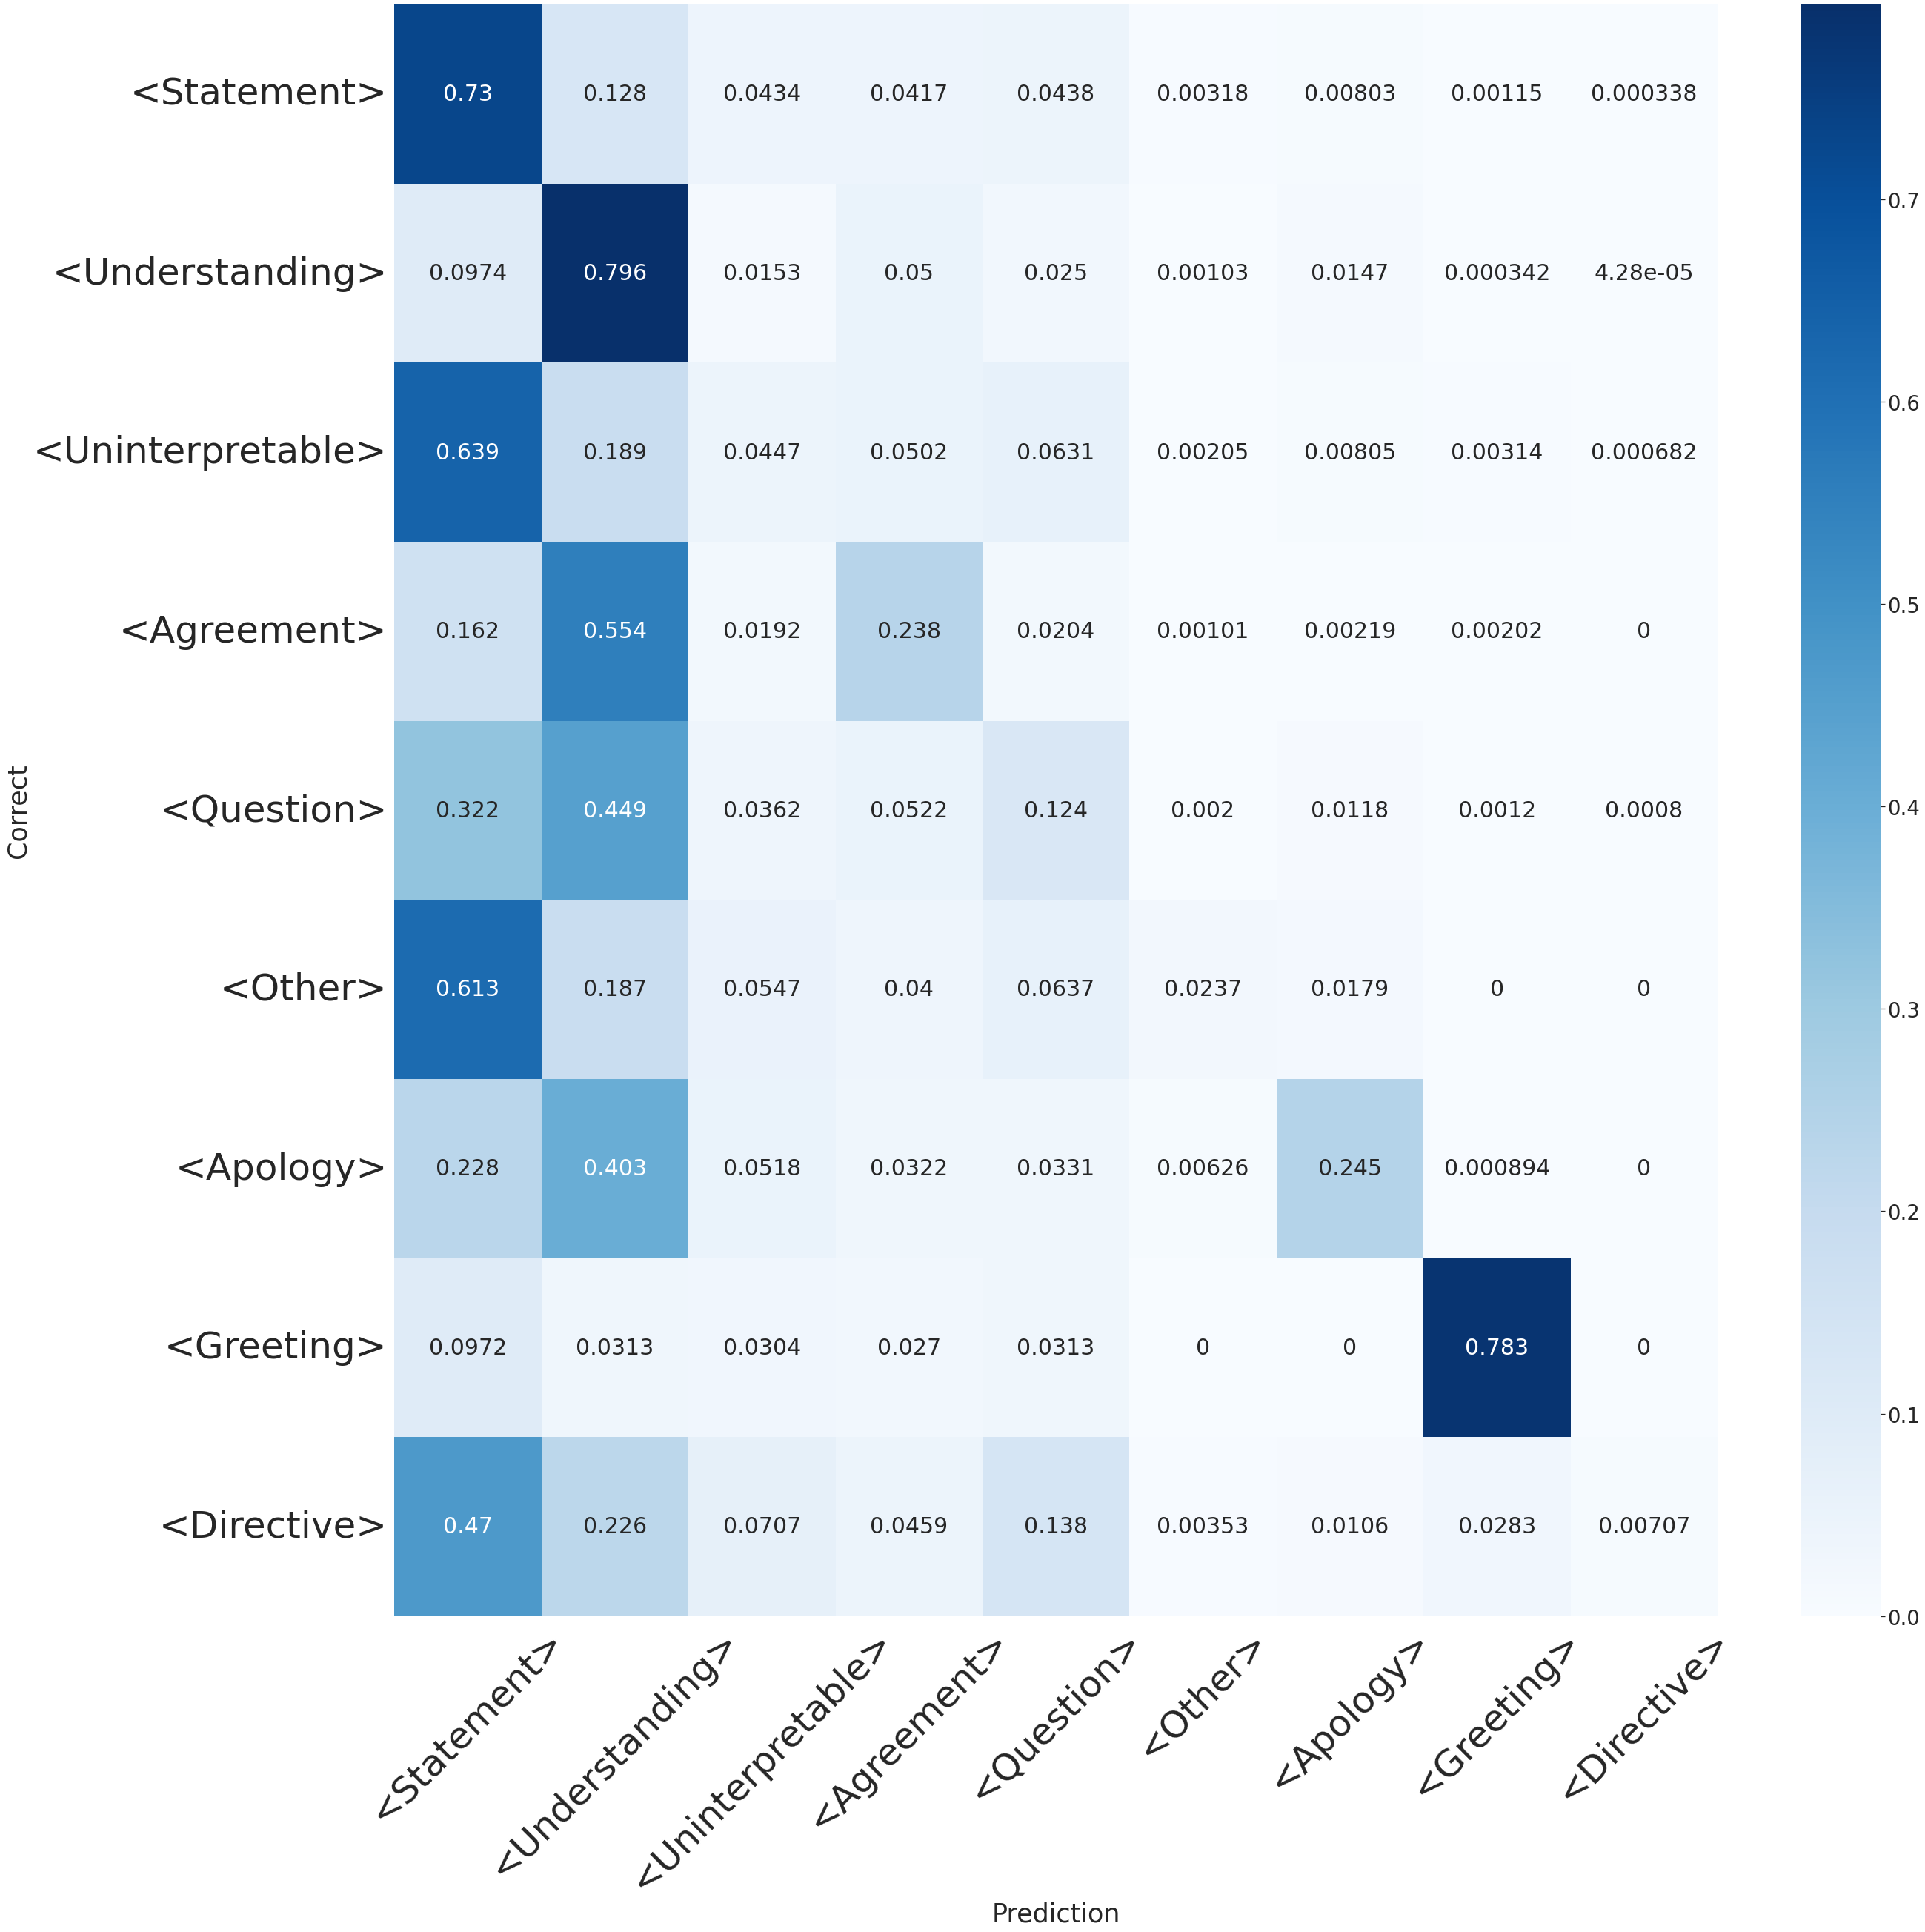

In [66]:
CreateConfusionMatrix(trues, preds)

In [56]:
stage=1

p:73.4  r:73.4  f:73.2  acc:73.2

p: 72.36647592285675 | r: 72.27096629952317 | f: 72.0519687686512 | acc: 72.06057777086251

F-Score
<Statement> 71.56145407705384
Other1 72.54248346024855

p: 74.32015722391844 | r: 74.36362303321829 | f: 74.29150173567864 | acc: 74.29905087910377

F-Score
<Statement> 74.73204360728964
Other1 73.85095986406763

p: 73.43799750657219 | r: 73.47031180130324 | f: 73.37601122699901 | acc: 73.3789741195996

F-Score
<Statement> 73.65687421732258
Other1      73.09514823667547


stage=2

p:45.8  r:34.5  f:36.1  acc:52.1

p: 45.69527932180993 | r: 34.293546865980815 | f: 34.88994206079214 | acc: 51.87762889727245

F-Score
None 0.0
<Understanding> 73.95880832953337
Other2 30.711017852843035

p: 46.87949703451089 | r: 35.33003667438046 | f: 37.72257293458139 | acc: 53.35848402064091

F-Score
None 0.0
<Understanding> 74.6202684240135
Other2 38.54745037973068

p: 44.74768319397261 | r: 33.85447280203202 | f: 35.55065797958664 | acc: 51.17297602012055

None 0.0
<Understanding> 73.28467730769992
Other2          33.367296631059986

stage=3

p:41.0  r:16.3  f:20.6  acc: 13.4

p: 32.62328344043661 | r: 14.196702980774328 | f: 17.446655555141543 | acc: 11.079845233907843

F-Score
None 0.0
<Uninterpretable> 3.416351545181901
<Agreement> 25.74775672981057
<Question> 10.998453342498712
<Other> 0.0
<Apology> 11.933534743202419
<Greeting> 87.47714808043875
<Directive> 0.0

p: 48.983330879658986 | r: 18.344006655316836 | f: 23.704256339540727 | acc: 15.911888849806544

F-Score
None 0.0
<Uninterpretable> 8.548052265233851
<Agreement> 34.485303160742845
<Question> 19.384758076982536
<Other> 4.415454089312594
<Apology> 34.54075032341527
<Greeting> 85.52935737401756
<Directive> 2.7303754266211606

p: 39.90207850916778 | r: 16.313904443320222 | f: 20.60988640607306 | acc: 13.265036932817445

F-Score
None 0.0
<Uninterpretable>  6.4956400859345385
<Agreement>       26.860346585117227
<Question>        18.043160798312506
<Other>            0.20964360587002098
<Apology>         25.70123939986954
<Greeting>        87.56906077348066
<Directive>        0.0

All   

p:32.7 r:31.3  f:30.7  acc: 59.5

<Statement>       73.3%
<Understanding>   63.5%
<Uninterpretable>  4.8%
<Agreement>       20.2%
<Question>        11.7%
<Other>            1.4%
<Apology>         16.2%
<Greeting>        84.2%
<Directive>        0.9%

p: 29.18747004485041 | r: 29.358182848693577 | f: 28.392378003590725 | acc: 57.95550023339039

F-Score
<Statement>       71.56145407705384
<Understanding>   61.90226293274812
<Uninterpretable>  2.8743828853538123
<Agreement>       17.10689740829676
<Question>         8.186236889229983
<Other>            0.0
<Apology>          8.946772366930917
<Greeting>        84.95339547270306
<Directive>        0.0

p: 36.23987127385482 | r: 33.228142041384686 | f: 33.118570029000125 | acc: 61.02276852860329

F-Score
<Statement>       74.73204360728964
<Understanding>   66.09246538776381
<Uninterpretable>  6.408495834477708
<Agreement>       24.641884172598644
<Question>        13.58613217768147
<Other>            4.025617566331198
<Apology>         23.237597911227155
<Greeting>        82.73703041144901
<Directive>        2.6058631921824107

p: 32.73578377605658 | r: 31.234535063782975 | f: 30.58724730176774 | acc: 59.56330065867953

F-Score
<Statement>       73.65687421732258
<Understanding>   62.55930572205245
<Uninterpretable>  5.223577235772358
<Agreement>       18.931297709923662
<Question>        13.312582305758408
<Other>            0.20887728459530025
<Apology>         16.4440734557596
<Greeting>        84.94863778472532
<Directive>        0.0

SyntaxError: invalid syntax (1885439556.py, line 3)

In [ ]:
<Statement>       
<Understanding>   
<Uninterpretable>  
<Agreement>       
<Question>        
<Other>            
<Apology>         
<Greeting>        
<Directive>     

## クラスタリング

In [ ]:
clustering_tSNE_path="./img/SwDA/tSNE"
from sklearn.manifold import TSNE

In [ ]:
@torch.no_grad()

def ModelTestClustering(models):
    result=[]
    for seq_idx in range(0, len(XDA_test)):
        print('\r{}/{} conversation evaluating'.format(seq_idx+1, len(XDA_test)), end='')
        
        X_seq = XDA_test[seq_idx]
        
        turn[seq_idx] = turn[seq_idx] + [0] * (len(X_seq) - len(turn[seq_idx]))
        turn_seq = turn[seq_idx]
        XU_seq = XUtt_test[seq_idx]
        
        utter_hidden, context_hidden, da_hidden = models.initDAHidden(1)

        for i in range(0, len(X_seq)):
            X_tensor = torch.tensor([[X_seq[i]]]).to(device)
            turn_tensor = torch.tensor([[turn_seq[i]]]).to(device)
            turn_tensor = turn_tensor.float()
            turn_tensor = turn_tensor.unsqueeze(1)   
            XU_tensor = torch.tensor([XU_seq[i]]).to(device)

            level1_pred, level2_pred, level3_pred, level4_pred, context_hidden, da_hidden = model.prediction(XU_tensor, X_tensor, None, context_hidden, da_hidden, turn_tensor)
            
        level4_pred = level4_pred.squeeze(1)
        x_numpy = level4_pred[0].to('cpu').detach().numpy().copy()
        result.append(x_numpy)
        
    return result

results=ModelTestClustering(model)

In [ ]:
targets = [YDA[-1] for YDA in YDA4_test]
output=np.array(results)
target=np.array(targets)

In [ ]:
def tSNE_Visualization(output, target, loss_name):
    
    if not os.path.isdir(clustering_tSNE_path):
        os.makedirs(clustering_tSNE_path)
        
    tsne = TSNE(n_components=2, random_state=41, n_iter=10000, perplexity=50.0, early_exaggeration=20.0, init='pca')
    X_reduced = tsne.fit_transform(output)

    f, ax = plt.subplots(1, 1, figsize=(13, 7))
    for idx in range(len(DA4_vocab.word2id)):
        targets=X_reduced[target==idx]
        plt.scatter(targets[:, 0], targets[:, 1],
                    label=DA4_vocab.id2word[idx],
                    cmap='jet',
                    s=15, alpha=0.5)
#     plt.axis('off')
#     plt.colorbar()
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')  
    plt.savefig(clustering_tSNE_path + "SwDA_Lossfunction{0}_Res2.png".format(loss_name))

In [ ]:
tSNE_Visualization(output, target, loss_name)

In [25]:
XDA1list = XDA1_train + XDA1_valid + XDA1_test
YDA1list = YDA1_train + YDA1_valid + YDA1_test
YDA2list = YDA2_train + YDA2_valid + YDA2_test
YDA3list = YDA3_train + YDA3_valid + YDA3_test
# YDA4list = YDA4_train + YDA4_valid + YDA4_test

print(len(XDA1list), len(YDA1list))

Sta_count=0
Oth1_count=0
MAX_count=0
for DA_list in YDA1list:
    for DA in DA_list:
        if DA==0:
            Sta_count+=1
        else:
            Oth1_count+=1
        MAX_count+=1  
        
print(Sta_count, Oth1_count, MAX_count)
print((Sta_count/MAX_count)*100, (Oth1_count/MAX_count)*100)

Und_count=0
Oth2_count=0
MAX_count=0
for DA_list in YDA2list:
    for DA in DA_list:
        if DA == -1:
            pass
        else:
            if DA == 0:
                Und_count+=1
            else:
                Oth2_count+=1
            MAX_count+=1
            
print(Und_count, Oth2_count, MAX_count)
print((Und_count/MAX_count)*100, (Oth2_count/MAX_count)*100)

# Uni_count=0
# Oth3_count=0
# MAX_count=0
# for DA_list in YDA3list:
#     for DA in DA_list:
#         if DA == -1:
#             pass
#         else:
#             if DA == 0:
#                 Uni_count+=1
#             else:
#                 Oth3_count+=1
#             MAX_count+=1
            
# print(Uni_count, Oth3_count, MAX_count)
# print((Uni_count/MAX_count)*100, (Oth3_count/MAX_count)*100)

Uni_count=0
Agr_count=0
Que_count=0
Oth_count=0
Apo_count=0
Gre_count=0
Dir_count=0
MAX_count=0
for DA_list in YDA3list:
    for DA in DA_list:
        if DA == -1:
            pass
        else:
            if DA == 0:
                Uni_count+=1
            elif DA == 1:
                Agr_count+=1
            elif DA == 2:
                Que_count+=1
            elif DA == 3:
                Oth_count+=1
            elif DA == 4:
                Apo_count+=1
            elif DA == 5:
                Gre_count+=1
            else:
                Dir_count+=1
            MAX_count+=1
            
print(Uni_count, Que_count, Agr_count, Apo_count, Gre_count, Oth_count, Dir_count, MAX_count)
print((Uni_count/MAX_count)*100,
      (Agr_count/MAX_count)*100, 
      (Que_count/MAX_count)*100, 
      (Oth_count/MAX_count)*100,
      (Apo_count/MAX_count)*100, 
      (Gre_count/MAX_count)*100,
      (Dir_count/MAX_count)*100)

192810 192810
501450 462600 964050
52.01493698459624 47.98506301540377
241160 221440 462600
52.131431041936885 47.86856895806312
73394 50573 55511 11143 8855 18681 3283 221440
33.14396676300578 25.068190028901732 22.838240606936417 8.436145231213873 5.032062861271677 3.9988258670520227 1.482568641618497
